# ML Notebook
## Bailey Snee and Trinity Gahagen

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# sklearn imports?
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_log_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [2]:
# import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Convert datetime column to datetime type and split into components

In [4]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['datetime'].dtype

dtype('<M8[ns]')

In [5]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

Drop datetime, atemp, and casual/registered columns.

In [6]:
# save a copy of training data that retains casual and registered columns
train_groups = train.drop(columns=['datetime', 'atemp'])

In [7]:
train = train.drop(columns=['datetime', 'atemp', 'casual', 'registered'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   humidity    10886 non-null  int64  
 6   windspeed   10886 non-null  float64
 7   count       10886 non-null  int64  
 8   year        10886 non-null  int32  
 9   month       10886 non-null  int32  
 10  day         10886 non-null  int32  
 11  hour        10886 non-null  int32  
dtypes: float64(2), int32(4), int64(6)
memory usage: 850.6 KB


# Model Building

In [12]:
# Splitting data into target/features
X = train.drop(columns='count')
y = train['count']

# Split training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
rf = RandomForestRegressor()

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
rf_param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
    
}

In [15]:
rf_cv = GridSearchCV(rf, rf_param, cv=3, scoring='neg_root_mean_squared_log_error', n_jobs=-1, verbose=10)

In [16]:
rf_cv.fit(X_train_scaled, y_train)

In [17]:
rf_cv.best_params_

{'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [69]:
rf_cv.best_score_

-0.3629732963242736

In [19]:
best_rf_model = rf_cv.best_estimator_

y_pred = best_rf_model.predict(X_test_scaled)

r2_score(y_test, y_pred)

In [20]:
gbr = GradientBoostingRegressor()

In [21]:
gbr_param = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [22]:
gbr_cv = GridSearchCV(gbr, gbr_param, cv=3, scoring='neg_root_mean_squared_log_error', n_jobs=-1, verbose=1)

In [46]:
gbr_cv.fit(X_train_scaled, y_train)

In [50]:
gbr_cv.best_params_

In [51]:
gbr_cv.best_score_

In [23]:
svr = SVR()

In [24]:
svr_param = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.5, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1]
}

In [25]:
svr_cv = GridSearchCV(svr, svr_param, cv=3, scoring='neg_root_mean_squared_log_error', n_jobs=-1, verbose=1)

In [66]:
svr_cv.fit(X_train_scaled, y_train)

In [67]:
svr_cv.best_params_

In [69]:
svr_cv.best_score_

In [71]:
best_svr_model = svr_cv.best_estimator_

y_pred = best_svr_model.predict(X_test_scaled)

r2_score(y_test, y_pred)

In [72]:
def cv_outputs(grid_cv, X=X_test_scaled, y=y_test):
    best_model = grid_cv.best_estimator_

    y_pred = best_model.predict(X)

    r2 = r2_score(y, y_pred)
    rmsle = grid_cv.best_score_

    print(f'Best Parameters: {grid_cv.best_params_}')    
    print(f'R^2: {r2}')
    print(f'RMSLE: {rmsle}')

In [27]:
# SGD Regression
sgd = SGDRegressor()

sgd_params = {
    'loss': ['spared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'eta0': [0.01, 0.1, 1],
    'max_iter': [1000, 2000]
}

sgd_cv = GridSearchCV(sgd, sgd_params, cv=3, scoring='neg_root_mean_squared_log_error', verbose=1)

In [27]:
sgd_cv.fit(X_train_scaled, y_train)

In [33]:
sgd_cv.best_params_

In [34]:
sgd_cv.best_score_

In [44]:
cv_outputs(sgd_cv)

In [28]:
# Ridge Regression
ridge = Ridge()
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'lbfgs']
}

ridge_cv = GridSearchCV(ridge, ridge_params, cv=3, scoring='neg_root_mean_squared_log_error', verbose=1)

In [29]:
ridge_cv.fit(X_train_scaled, y_train)

In [30]:
cv_outputs(ridge_cv)

In [31]:
ridge_cv.best_score_

In [ ]:
# estimator = ridge_cv.best_estimator_
# plt.bar(x=range(len(estimator.coef_)), height=estimator.coef_)
# plt.tick_params(axis=x, list(X_train.columns))
# plt.show()

In [32]:
# XGBoost Regression
xgb_regressor = xgb.XGBRegressor()

xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_cv = GridSearchCV(xgb_regressor, xgb_params, cv=3, scoring='neg_root_mean_squared_log_error', verbose=1)

In [33]:
xgb_cv.fit(X_train_scaled, y_train)

In [36]:
cv_outputs(xgb_cv)

Next steps:
- Make a submission for the random forest to see what Kaggle says
- Tackle improvements

In [27]:
test = pd.read_csv('test.csv')

In [28]:
# preprocess test data
test['datetime'] = pd.to_datetime(test['datetime'])
test['datetime'].dtype

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

# we need datetime for our submission file, so save it as a series
test_datetime = test['datetime']

test = test.drop(columns=['datetime', 'atemp'])

In [29]:
# transform test data
test_preprocessed = scaler.transform(test)

In [30]:
# predict bike rentals using rf model
y_rf = best_rf_model.predict(test_preprocessed)

In [ ]:
# Saving the already fitted random forest model
filename = 'first_rf_model.sav'
pickle.dump(best_rf_model, open(filename, 'wb'))

In [31]:
# create dataframe for submission
pred_df = pd.DataFrame({'datetime': test_datetime, 'count': pd.Series(y_rf)})

In [32]:
pred_df.head()

In [37]:
pred_df.to_csv('rf_submission.csv', index=False)

Kaggle score: 0.48552\
Rank: 1345 / 32,000

# Improving Our Model

In [41]:
X_train.head()

Trying things:
- Drop `day`, `humidity`
- One hot encode `season`

In [ ]:
train_v2 = train.drop(columns=['day'])
onehot_seasons = pd.get_dummies(train_v2['season'], dtype=int, prefix='season')

train_v2 = pd.concat([onehot_seasons, train_v2], axis=1)
train_v2.drop(columns='season', inplace=True)
train_v2.head()

,season_1,season_2,season_3,season_4,holiday,workingday,weather,temp,windspeed,count,year,month,hour
0,1,0,0,0,0,0,1,9.84,0.0,16,2011,1,0
1,1,0,0,0,0,0,1,9.02,0.0,40,2011,1,1
2,1,0,0,0,0,0,1,9.02,0.0,32,2011,1,2
3,1,0,0,0,0,0,1,9.84,0.0,13,2011,1,3
4,1,0,0,0,0,0,1,9.84,0.0,1,2011,1,4


In [9]:
X = train_v2.drop(columns='count')
y = train_v2['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

scaler_v2 = StandardScaler()

X_train_scaled = scaler_v2.fit_transform(X_train)

NameError: name 'train_v2' is not defined

In [75]:
X_test_scaled = scaler_v2.transform(X_test)

In [46]:
rf_new_params = {
    'max_depth': [15, 20, 25, None],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 300, 400]
}

In [49]:
rf_cv_2 = GridSearchCV(rf, rf_new_params, cv=4, scoring='neg_root_mean_squared_log_error', n_jobs=-1, verbose=1)

In [54]:
rf_cv_2.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


c:\Users\baile\anaconda3\envs\bike_env\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_root_mean_squared_log_error', verbose=1)

In [67]:
rf_cv_2.best_score_

-0.36249385444140914

In [68]:
rf_cv_2.best_params_

{'max_depth': 15,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

In [71]:
rf_cv.best_params_

{'max_depth': 20,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [76]:
cv_outputs(rf_cv_2, X=X_test_scaled, y=y_test)

Best Parameters: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
R^2: 0.9331350347799783
RMSLE: -0.36249385444140914


In [99]:
# Saving second model
filename = 'second_rf_model.sav'
pickle.dump(rf_cv_2.best_estimator_, open(filename, 'wb'))

In [8]:
# transform hour and month columns using trig functions
try:
    train['hour_cos'] = train['hour'].apply(np.cos)
    train['month_cos'] = train['month'].apply(np.cos)

    train = train.drop(columns=['hour', 'month'])
except:
    print('Already dropped')

In [33]:
X = train.drop(columns='count')
y = train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

scaler_v2 = StandardScaler()

X_train_scaled = scaler_v2.fit_transform(X_train)
X_test_scaled = scaler_v2.transform(X_test)

In [90]:
# try RandomForest model after transforming the hour and month columns
rf_cos = RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=400)
rf_cos.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=2,
                      n_estimators=400)

In [92]:
rf_cos.score(X_test_scaled, y_test)

0.894999971017552

In [93]:
y_pred = rf_cos.predict(X_test_scaled)
root_mean_squared_log_error(y_test, y_pred)

0.5898700172863549

Next Steps:
- Look at better model algorithms
- Casual/registered stuff
- Re-enter humidity

In [7]:
with open('first_rf_model.sav', 'rb') as file:
    first_rf_model = pickle.load(file)

In [21]:
first_rf_model.score(X_test_scaled, y_test)


-0.5827561039128044

Create separate models for casual and registered riders

In [9]:
train_groups.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,75,0.0,0,1,1,2011,1,1,4


In [11]:
# X will remain the same as before
# could code this here as
# X = train_groups.drop(columns=['casual', 'registered', 'count'])

# we need a separate y for casual and registered
y_cas = train_groups['casual']
y_reg = train_groups['registered']

In [12]:
# split training data
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(X, y_cas, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [26]:
rf_cas = RandomForestRegressor()
rf_reg = RandomForestRegressor()

In [34]:
# scale our data
scaler = StandardScaler()

X_train_cas_scaled = scaler.fit_transform(X_train_cas)
X_train_reg_scaled = scaler.fit_transform(X_train_reg)

X_test_cas_scaled = scaler.transform(X_test_cas)
X_test_reg_scaled = scaler.transform(X_test_reg)

In [28]:
# we can use the same model parameters as before
rf_params = {
    'max_depth': [15, 20, 25, None],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 300, 400]
}

In [33]:
rf_cas_cv = GridSearchCV(rf_cas, rf_params, cv=3, scoring='neg_root_mean_squared_log_error', n_jobs=-1, verbose=10)

In [34]:
rf_cas_cv.fit(X_train_cas_scaled, y_train_cas)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_root_mean_squared_log_error', verbose=10)

In [36]:
rf_reg_cv = GridSearchCV(rf_reg, rf_params, cv=3, scoring='neg_root_mean_squared_log_error', n_jobs=-1, verbose=10)

In [37]:
rf_reg_cv.fit(X_train_reg_scaled, y_train_reg)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 400]},
             scoring='neg_root_mean_squared_log_error', verbose=10)

In [38]:
rf_cas_cv.best_score_

-0.9117224403450411

In [39]:
rf_reg_cv.best_score_

-0.5063259851921014

Now that we have models for both casual and registered riders, we can save them for later.

In [40]:
# Saving the casual model
filename = 'rf_casual_model.sav'
pickle.dump(rf_cas_cv.best_estimator_, open(filename, 'wb'))

In [41]:
# Saving the registered model
filename = 'rf_registered_model.sav'
pickle.dump(rf_reg_cv.best_estimator_, open(filename, 'wb'))

In [15]:
# For brevity after closing each session, we reload the models and predict values again
with open('rf_casual_model.sav', 'rb') as file:
    rf_cas = pickle.load(file)

with open('rf_registered_model.sav', 'rb') as file:
    rf_reg = pickle.load(file)

In [13]:
# predict casual and registered riders using our best model
y_cas_pred = rf_cas_cv.best_estimator_.predict(X_test_cas_scaled)
y_reg_pred = rf_reg_cv.best_estimator_.predict(X_test_reg_scaled)

NameError: name 'rf_cas_cv' is not defined

In [35]:
# predict casual and registered riders using our best model
y_cas_pred = rf_cas.predict(X_test_cas_scaled)
y_reg_pred = rf_reg.predict(X_test_reg_scaled)

In [36]:
# sum together to get our total count
y_tot_pred = y_cas_pred + y_reg_pred

In [37]:
y_tot = y_test_cas + y_test_reg

In [38]:
root_mean_squared_log_error(y_tot, y_tot_pred)

1.523605318171259

In [39]:
train_groups.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,75,0.0,0,1,1,2011,1,1,4


In [40]:
# create a dataframe containing the predicted values
X_test_diff = X_test_cas.copy()

X_test_diff['casual'] = y_test_cas
X_test_diff['registered'] = y_test_reg
X_test_diff['cas_pred'] = y_cas_pred
X_test_diff['reg_pred'] = y_reg_pred

# calculate difference between prediction and actual value
X_test_diff['error'] = (X_test_diff['cas_pred'] - X_test_diff['casual']).abs()

In [41]:
X_test_diff.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,casual,registered,cas_pred,reg_pred,error
3133,3,0,1,1,33.62,59,0.0000,2011,7,19,11,29,98,31.787813,34.560000,2.787813
5786,1,1,0,1,4.10,54,6.0032,2012,1,16,6,0,13,3.567354,78.970583,3.567354
5224,4,0,0,1,9.84,48,12.9980,2011,12,11,18,12,151,12.754472,156.906250,0.754472
8953,3,0,1,2,29.52,62,12.9980,2012,8,15,10,70,163,66.367988,725.744688,3.632012
8054,2,0,1,1,25.42,53,16.9979,2012,6,15,23,46,176,42.418399,667.634280,3.581601


In [42]:
X_test_diff.nlargest(10, 'error')

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,casual,registered,cas_pred,reg_pred,error
6800,2,0,0,1,20.50,55,16.9979,2012,4,1,15,295,278,56.980719,122.330000,238.019281
6729,1,0,0,1,26.24,50,0.0000,2012,3,17,16,367,318,158.960903,303.774670,208.039097
6940,2,0,0,1,18.86,23,26.0027,2012,4,7,12,320,270,117.786872,53.665000,202.213128
6749,1,0,0,2,18.04,88,8.9981,2012,3,18,12,222,281,20.117552,71.940000,201.882448
7685,2,0,0,1,29.52,30,6.0032,2012,5,19,14,361,369,161.955514,124.647500,199.044486
9656,4,0,0,1,22.14,49,26.0027,2012,10,6,17,268,342,75.934691,95.039375,192.065309
6728,1,0,0,1,26.24,53,8.9981,2012,3,17,15,357,322,166.845009,297.870776,190.154991
6753,1,0,0,1,22.14,73,6.0032,2012,3,18,16,229,312,43.481071,88.905000,185.518929
6939,2,0,0,1,18.04,24,19.9995,2012,4,7,11,251,244,68.059554,54.252500,182.940446
6942,2,0,0,1,20.50,22,19.9995,2012,4,7,14,326,252,144.631844,54.315000,181.368156


In [43]:
X_test_diff['season'].value_counts()

season
4    547
3    546
1    546
2    539
Name: count, dtype: int64

<Axes: xlabel='season', ylabel='count'>

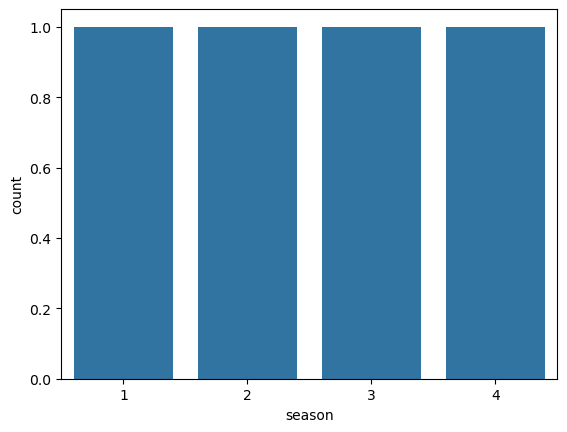

In [44]:
sns.countplot(X_test_diff['season'].value_counts())

In [26]:
colors = sns.palette('tab10')
columns = ['season', 'holiday', 'workingday', 'weather', 'month', 'hour', 'day']
errors = X_test_diff[X_test_diff['error'] > 100]
fig, axes = plt.subplots(4, 2, figsize=(12,10))
for n, column in enumerate(columns):
    ax = axes[n // 2][n % 2]
    data = errors[column].value_counts()
    sns.barplot(x=data.index, y=data, ax=ax)
    ax.set_xlabel(column.title())
    ax.set_title(f'Value Counts for {column}')
plt.tight_layout()

AttributeError: module 'seaborn' has no attribute 'palette'

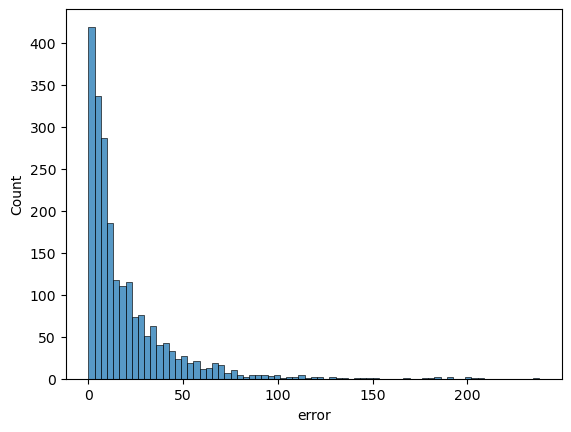

In [25]:
sns.histplot(X_test_diff['error'])
plt.show()

In [27]:
# Filter for error values above 150?
X_test_diff.loc[X_test_diff['error'] > 150, 'year'].value_counts()

year
2012    13
Name: count, dtype: int64

In [47]:
# recreate datetime column
date_time = X_test_diff['year'].astype(str) + '-' + X_test_diff['month'].astype(str) + '-' + X_test_diff['day'].astype(str) + ' ' + X_test_diff['hour'].astype(str) + ':00:00'
X_test_diff['datetime'] = date_time
X_test_diff['datetime'] = pd.to_datetime(X_test_diff['datetime'])
X_test_diff.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,casual,registered,cas_pred,reg_pred,error,datetime
3133,3,0,1,1,33.62,59,0.0000,2011,7,19,11,29,98,31.787813,34.560000,2.787813,2011-07-19 11:00:00
5786,1,1,0,1,4.10,54,6.0032,2012,1,16,6,0,13,3.567354,78.970583,3.567354,2012-01-16 06:00:00
5224,4,0,0,1,9.84,48,12.9980,2011,12,11,18,12,151,12.754472,156.906250,0.754472,2011-12-11 18:00:00
8953,3,0,1,2,29.52,62,12.9980,2012,8,15,10,70,163,66.367988,725.744688,3.632012,2012-08-15 10:00:00
8054,2,0,1,1,25.42,53,16.9979,2012,6,15,23,46,176,42.418399,667.634280,3.581601,2012-06-15 23:00:00


In [29]:
# create subset of data containing only records from march 2012
march_records = X_test_diff.loc[(X_test_diff['year'] == 2012) & (X_test_diff['month'] == 3)]

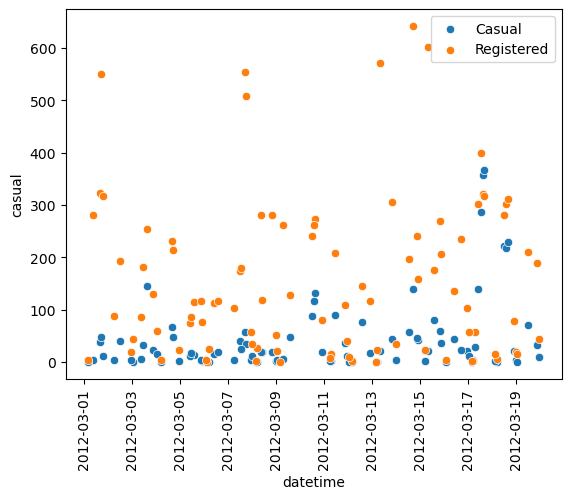

In [30]:
# plot bike rentals by hour for the month of march
sns.scatterplot(data=march_records, x='datetime', y='casual', label='Casual')
sns.scatterplot(data=march_records, x='datetime', y='registered', label='Registered')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [48]:
X_test_diff.loc[X_test_diff['datetime'].dt.date == pd.to_datetime('2012-04-08').date()]

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour,casual,registered,cas_pred,reg_pred,error,datetime
6967,2,0,0,1,25.42,17,23.9994,2012,4,8,15,260,226,209.394673,277.3725,50.605327,2012-04-08 15:00:00
6955,2,0,0,1,17.22,26,8.9981,2012,4,8,3,8,18,64.791506,267.9800,56.791506,2012-04-08 03:00:00
6954,2,0,0,1,18.04,24,15.0013,2012,4,8,2,7,25,56.026439,271.1300,49.026439,2012-04-08 02:00:00
6959,2,0,0,1,15.58,27,11.0014,2012,4,8,7,12,25,53.394443,248.2400,41.394443,2012-04-08 07:00:00
6965,2,0,0,1,23.78,23,11.0014,2012,4,8,13,229,254,165.388654,280.0775,63.611346,2012-04-08 13:00:00


In [49]:
pd.Series(X_test_diff.loc[X_test_diff['holiday'] == 1]['datetime'].dt.date.unique()).sort_values()

9     2011-01-17
3     2011-04-15
11    2011-07-04
1     2011-09-05
6     2011-10-10
5     2012-01-02
0     2012-01-16
10    2012-04-16
2     2012-07-04
4     2012-09-03
8     2012-10-08
7     2012-11-12
dtype: object

In [ ]:
# training_set = train.copy()
# training_set.loc[training_set['holiday'] == 1].groupby('datetime')[['datetime', 'count']].sort_values()

KeyError: 'datetime'

In [32]:
X_test_diff['datetime'].describe()

count                             2178
mean     2011-12-27 09:36:38.347107328
min                2011-01-01 00:00:00
25%                2011-07-03 16:30:00
50%                2012-01-02 11:30:00
75%                2012-07-01 07:15:00
max                2012-12-19 23:00:00
Name: datetime, dtype: object

## Observations:
- some holidays are missing (easter, veteran's day, st patrick's day)
- it might be useful to create a feature relating to days adjacent to holiday/holiday weekend
- Don't forget to look up stupid stuff like "National Bike to School Day"

In [57]:
X_test_diff['holiday'].value_counts()

holiday
0    2121
1      57
Name: count, dtype: int64

C:\Users\baile\AppData\Local\Temp\ipykernel_9028\2031551876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  march_by_days['total'] = march_by_days['casual'] + march_by_days['registered']


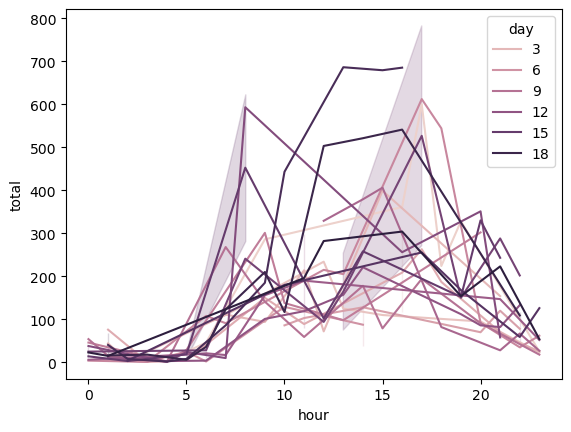

In [39]:
%matplotlib inline
fig, ax = plt.subplots()
colors = sns.color_palette('tab10')
march_by_days = march_records[['day', 'hour', 'casual', 'registered']]
march_by_days['total'] = march_by_days['casual'] + march_by_days['registered']
sns.lineplot(data=march_by_days, x='hour', y='total', hue='day', ax=ax)
plt.show()

# Last Ditch Efforts: Trying the LightGBM Model

* investigate holidays and holiday adjacent days
* set 3-17 to holiday (and any other days that are not marked but should be)

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   humidity    10886 non-null  int64  
 6   windspeed   10886 non-null  float64
 7   year        10886 non-null  int32  
 8   month       10886 non-null  int32  
 9   day         10886 non-null  int32  
 10  hour        10886 non-null  int32  
dtypes: float64(2), int32(4), int64(5)
memory usage: 765.6 KB


To potentially improve the model, we'll add in extra holiday flags for holidays not included in the original dataset.

In [ ]:
# St. Paddy's Day
X.loc[(X['day'] == 17) & (X['month'] == 3), 'holiday'] = 1
# Easter Sunday
X.loc[(X['day'] == 8) & (X['month'] == 4) & (X['year'] == 2012), 'holiday'] = 1
X.loc[(X['day'] == 24) & (X['month'] == 4) & (X['year'] == 2011), 'holiday'] = 1
# 

### To Do
* Determine which holidays to mark
* Mark holidays
* Run model again and check performance
* Try LightGBM model and check performance